**1. GraphQA**

In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain.prompts.prompt import PromptTemplate
from langchain_neo4j import Neo4jGraph
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain

In [23]:
import importlib.metadata as md

print("langchain:", md.version("langchain"))
print("langchain-core:", md.version("langchain-core"))
print("langchain-openai:", md.version("langchain-openai"))
print("langchain-neo4j:", md.version("langchain-neo4j"))
print("langgraph:", md.version("langgraph"))
print("neo4j:", md.version("neo4j"))

langchain: 0.3.26
langchain-core: 0.3.74
langchain-openai: 0.3.28
langchain-neo4j: 0.5.0
langgraph: 0.4.8
neo4j: 5.28.2


In [ ]:
# Initial the openai_api_key
openai_api_key= "Add Your OpenAI API KEY Here."

In [3]:
# Initial the Neo4j dataset
NEO4J_URL = 'bolt://localhost:7687'
NEO4J_USERNAME = 'neo4j'
NEO4J_PASSWORD = 'your_password_here'

kg = Neo4jGraph(url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

In [4]:
# Build CypherQA Chain
schema_raw = kg.query("CALL db.schema.visualization()")

def format_schema(raw_schema):
    """Format the schema into a concise string description"""
    nodes = [node['name'] for node in raw_schema[0]['nodes']]
    relationships = [
        f"({rel[0]['name']})-[:{rel[1]}]->({rel[2]['name']})"
        for rel in raw_schema[0]['relationships']
    ]
    return f"Nodes:\n{', '.join(nodes)}\n\nRelationships:\n" + "\n".join(relationships)


formatted_schema = format_schema(schema_raw)

CYPHER_GENERATION_TEMPLATE = """Task: Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema. Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Note: 
[1] Do not include any explanations or apologies in your responses. Do not respond to any questions that might ask anything else than for you to construct a Cypher statement. Do not include any text except the generated Cypher statement.
[2] The functional unit includes FunctionalUnit_Quantity, FunctionalUnit_Unit, and FunctionalUnit_Product.
[2] The LCIA results includes Impact_Category, Impact_Category_Value, and Impact_Category_Unit.
[3] The inventory (or input-output) data represents all input and output Flows of Activity. They include Flow name, Amount, Unit, and 'Has_Input_Flow'/'Has_Output_Flow' relationships.

Known properties:
known_properties = {{
    "Activity": ["name", "page_number", "table_location", "technical_pathway"],
    "Amount": ["value"],
    "Flow": ["name", "is_reference_flow"],
    "FunctionalUnit_Product": ["name"],
    "FunctionalUnit_Quantity": ["value"],
    "FunctionalUnit_Unit": ["name"],
    "Geography": ["name"],
    "Impact_Category": ["name"],
    "Impact_Category_Value": ["value"],
    "Impact_Category_Unit": ["name"],
    "LCIA_Method": ["name"],
    "LCIA_result": ["name", "technical_pathway"],
    "Paper_Title": ["name"],
    "Reference_Product": ["name"],
    "Sector": ["name"],
    "System_Boundary": ["name"],
    "Unit": ["name"]
}}

Example:
# The inventory data for "Lebedev process pathway" pathway of the "1,3-Butadiene production" activity.
MATCH (a:Activity {{name: '1,3-Butadiene production', technical_pathway: 'Lebedev process pathway'}})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction

The question is:
{question}
"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"],
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
    return_intermediate_steps=True,
)

In [5]:
# Example query
question = "How many reference Products in Chemical sector? List all their name"
response = cypherChain.invoke({"query": question, "schema": formatted_schema})
print(response['result'])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (rp:Reference_Product)-[:Has_Sector]->(s:Sector {name: 'Chemical'})
RETURN rp.name AS reference_product_name, count(rp) AS number_of_reference_products

Full Context:
[{'reference_product_name': 'p-Xylene', 'number_of_reference_products': 1}, {'reference_product_name': 'Sorbitol', 'number_of_reference_products': 1}, {'reference_product_name': 'Citric acid', 'number_of_reference_products': 1}, {'reference_product_name': 'FDCA', 'number_of_reference_products': 1}, {'reference_product_name': 'Levulinic acid', 'number_of_reference_products': 1}, {'reference_product_name': 'Furfural', 'number_of_reference_products': 1}, {'reference_product_name': 'Xylitol', 'number_of_reference_products': 1}, {'reference_product_name': 'Itaconic acid', 'number_of_reference_products': 1}, {'reference_product_name': '1,3-Butadiene', 'number_of_reference_products': 1}, {'reference_product_name': 'Butanol', 'number_of_reference_products

In [6]:
question = "Input and Output data of Ethylene production through technical_pathway Corn-grain-based pathway"
response = cypherChain.invoke({"query": question, "schema": formatted_schema})
print(response['result'])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'Ethylene production', technical_pathway: 'Corn-grain-based pathway'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[{'flow_name': 'Cooling water', 'amount': 462.2, 'unit': 'GJ/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Makeup water', 'amount': 407.0, 'unit': 't/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Power', 'amount': 28.8, 'unit': 'MW', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Natural gas', 'amount': 693.6, 'unit': 'MMBTU/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'CO2 emissions', 'amount': 37.6, 'unit': 't/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Ethylene', 'amount': 125.0, 'unit': 'kt/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'NaOH', 'amount':

In [7]:
question = "Input and Output data of ethylene production through technical_pathway Corn-grain-based pathway"
response = cypherChain.invoke({"query": question, "schema": formatted_schema})
print(response['result'])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'ethylene production', technical_pathway: 'Corn-grain-based pathway'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[]

> Finished chain.
I don't know the answer.


In [8]:
question = "Input and Output data of ethylene production from wood fermentation pathway"
response = cypherChain.invoke({"query": question, "schema": formatted_schema})
print(response['result'])



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'ethylene production', technical_pathway: 'wood fermentation pathway'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[]

> Finished chain.
I don't know the answer.


**2. GraphMAQA**

In [24]:
import os
import json
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain.schema import Document
from langchain_community.vectorstores import Neo4jVector
from langchain_neo4j import Neo4jGraph
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal, TypedDict, List, Optional, Any, Dict

In [8]:
import sys
import importlib.metadata as md

# Standard library (version == Python version)
print("python:", sys.version)

# LangChain ecosystem
print("langchain:", md.version("langchain"))
print("langchain-core:", md.version("langchain-core"))
print("langchain-openai:", md.version("langchain-openai"))
print("langchain-community:", md.version("langchain-community"))
print("langchain-neo4j:", md.version("langchain-neo4j"))
print("langgraph:", md.version("langgraph"))

# Neo4j driver
print("neo4j:", md.version("neo4j"))

python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
langchain: 0.3.26
langchain-core: 0.3.74
langchain-openai: 0.3.28
langchain-community: 0.3.25
langchain-neo4j: 0.5.0
langgraph: 0.4.8
neo4j: 5.28.2


In [10]:
# Initialize the OpenAI API key and connect to the Neo4j dataset as before

In [11]:
# Build CypherQA Chain
schema_raw = kg.query("CALL db.schema.visualization()")

def format_schema(raw_schema):
    """Format the schema into a concise string description"""
    nodes = [node['name'] for node in raw_schema[0]['nodes']]
    relationships = [
        f"({rel[0]['name']})-[:{rel[1]}]->({rel[2]['name']})"
        for rel in raw_schema[0]['relationships']
    ]
    return f"Nodes:\n{', '.join(nodes)}\n\nRelationships:\n" + "\n".join(relationships)


formatted_schema = format_schema(schema_raw)

CYPHER_GENERATION_TEMPLATE = """Task: Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema. Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Note: 
[1] Do not include any explanations or apologies in your responses. Do not respond to any questions that might ask anything else than for you to construct a Cypher statement. Do not include any text except the generated Cypher statement.
[2] The functional unit includes FunctionalUnit_Quantity, FunctionalUnit_Unit, and FunctionalUnit_Product.
[2] The LCIA results includes Impact_Category, Impact_Category_Value, and Impact_Category_Unit.
[3] The inventory (or input-output) data represents all input and output Flows of Activity. They include Flow name, Amount, Unit, and 'Has_Input_Flow'/'Has_Output_Flow' relationships.

Known properties:
known_properties = {{
    "Activity": ["name", "page_number", "table_location", "technical_pathway"],
    "Amount": ["value"],
    "Flow": ["name", "is_reference_flow"],
    "FunctionalUnit_Product": ["name"],
    "FunctionalUnit_Quantity": ["value"],
    "FunctionalUnit_Unit": ["name"],
    "Geography": ["name"],
    "Impact_Category": ["name"],
    "Impact_Category_Value": ["value"],
    "Impact_Category_Unit": ["name"],
    "LCIA_Method": ["name"],
    "LCIA_result": ["name", "technical_pathway"],
    "Paper_Title": ["name"],
    "Reference_Product": ["name"],
    "Sector": ["name"],
    "System_Boundary": ["name"],
    "Unit": ["name"]
}}

Example:
# The inventory data for "Lebedev process pathway" pathway of the "1,3-Butadiene production" activity.
MATCH (a:Activity {{name: '1,3-Butadiene production', technical_pathway: 'Lebedev process pathway'}})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction

The question is:
{question}
"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"],
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
    return_intermediate_steps=True,
)

In [12]:
# Build vector stores
embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

#create an embedding index for the node type of Activity
vectorstore_activity = Neo4jVector.from_existing_graph(
    embedding=embedding,
    url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    index_name="pathway",
    node_label="Activity",
    text_node_properties=["name", 'technical_pathway'],
    embedding_node_property="pathway_embedding",
)

# Create an embedding index for the node type of Reference_Product
vectorstore_reference_product = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(openai_api_key=openai_api_key),
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='product',
    node_label="Reference_Product",  
    text_node_properties=['name'],
    embedding_node_property='product_embedding', 
)

# Create an embedding index for the node type of Geography
vectorstore_geography = Neo4jVector.from_existing_graph(
    embedding=embedding,
    url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    index_name="geography",
    node_label="Geography",
    text_node_properties=["name"],
    embedding_node_property="geography_embedding",
)

# Create an embedding index for the node type of Paper_title
vectorstore_paper_title = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(openai_api_key=openai_api_key),
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='paper_title',
    node_label="Paper_Title",  
    text_node_properties=['name'],
    embedding_node_property='paper_title_embedding', 
)

# Create an embedding index for the node type of System_Boundary
vectorstore_system_boundary = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(openai_api_key=openai_api_key),
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='system_boundar',
    node_label="System_Boundary",  
    text_node_properties=['name'],
    embedding_node_property='system_boundar_embedding', 
)

# Create an embedding index for the node type of LCIA_result
vectorstore_LCIA_result = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(openai_api_key=openai_api_key),
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='LCIA_result',
    node_label='LCIA_result',  
    text_node_properties=['name', 'technical_pathway'],
    embedding_node_property='LCIA_result_embedding', 
)

# Create an embedding index for the node type of LCIA_Method
vectorstore_LCIA_Method = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(openai_api_key=openai_api_key),
    url=NEO4J_URL,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='LCIA_method',
    node_label='LCIA_Method',  
    text_node_properties=['name'],
    embedding_node_property='LCIA_method_embedding', 
)

# Create an embedding index for the node type of FunctionalUnit_Product
vectorstore_fu_product = Neo4jVector.from_existing_graph(
    embedding=embedding,
    url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    index_name="fu_product",
    node_label="FunctionalUnit_Product",
    text_node_properties=["name"],
    embedding_node_property="fu_product_embedding",
)

# Create an embedding index for the node type of FunctionalUnit_Unit
vectorstore_fu_unit = Neo4jVector.from_existing_graph(
    embedding=embedding,
    url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    index_name="fu_unit",
    node_label="FunctionalUnit_Unit",
    text_node_properties=["name"],
    embedding_node_property="fu_unit_embedding",
)

# Create an embedding index for the node type of Flow
vectorstore_flow = Neo4jVector.from_existing_graph(
    embedding=embedding,
    url=NEO4J_URL, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    index_name="flow",
    node_label="Flow",
    text_node_properties=["name"],
    embedding_node_property="flow_embedding",
)

In [13]:
# Build vector retrievers
retrievers: Dict[str, any] = {
    "activity": vectorstore_activity.as_retriever(search_kwargs={"k": 1}),
    "product": vectorstore_reference_product.as_retriever(search_kwargs={"k": 1}),
    "geography": vectorstore_geography.as_retriever(search_kwargs={"k": 1}),
    "paper_title": vectorstore_paper_title.as_retriever(search_kwargs={"k": 1}),
    "system_boundary": vectorstore_system_boundary.as_retriever(search_kwargs={"k": 1}),
    "lcia_result": vectorstore_LCIA_result.as_retriever(search_kwargs={"k": 1}),
    "lcia_method": vectorstore_LCIA_Method.as_retriever(search_kwargs={"k": 1}),
    "fu_product": vectorstore_fu_product.as_retriever(search_kwargs={"k": 1}),
    "fu_unit": vectorstore_fu_unit.as_retriever(search_kwargs={"k": 1}),
    "flow": vectorstore_flow.as_retriever(search_kwargs={"k": 1}),
}

AVAILABLE_INDEXES = sorted(retrievers.keys())

In [14]:
# Develop the workflow for similarity search and query rewriting.
VECTOR_ROUTER_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "Select the most relevant vector indexes for the user's question from this set:\n"
     "{indexes}\n\n"
     "Return ONLY JSON of the form: {{\"indexes\": [<one or more of the keys above>]}}\n"
     "Guidance:\n"
     "- activity: Activities, technical_pathway, unit-process IO\n"
     "- product: Reference_Product names, sector lists\n"
     "- geography: Geography names/filters\n"
     "- paper_title: paper/document titles\n"
     "- system_boundary: boundary terms (cradle-to-gate, etc.)\n"
     "- lcia_result: result nodes with technical_pathway\n"
     "- lcia_method: LCIA method names\n"
     "- flow: Flow names\n"
     "- fu_product/fu_unit: functional unit components"),
    ("human", "Question: {question}")
])

REWRITE_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are a query rewriter that aligns the user's question with exact Neo4j schema terms "
     "(node labels, property names, and values). "
     "Your rewrite must:\n"
     "1) Preserve the user's original intent.\n"
     "2) Fully use the retrieved results to match terms exactly (including casing and punctuation).\n"
     "3) Do NOT invent new facts, terms, or entities not found in the retrieved results.\n"
     "4) Output only the rewritten question, as a single line, with no explanations."),
    ("human",
     "Rewrite the following question so that all terms match exactly those in the retrieved results.\n\n"
     "Original question:\n{question}\n\n"
     "Retrieved results:\n{snippets}\n")
])

def pick_indexes(question: str):
    """Ask the LLM to select the relevant vector indexes."""
    msg = VECTOR_ROUTER_PROMPT.format_messages(
        indexes=", ".join(AVAILABLE_INDEXES),
        question=question
    )
    response = llm.invoke(msg).content.strip()
    try:
        index_list = json.loads(response).get("indexes", [])
    except Exception:
        index_list = []
    return index_list

def retrieve_from_indexes(question: str):
    """Retrieve relevant documents from selected vector stores."""
    chosen_indexes = pick_indexes(question)
    results = {}
    for idx in chosen_indexes:
        retriever = retrievers.get(idx)
        if retriever:
            docs = retriever.invoke(question)
            results[idx] = docs
    return results

In [15]:
# Build LangGraph pipeline
class State(TypedDict):
    question: str
    route: Optional[Literal["sim_then_cypher", "cypher_only"]]
    vector_docs: List[Document]
    rewritten_question: Optional[str]
    cypher_answer: Optional[str]
    messages: List[Dict[str, Any]]

llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
embedding_model = OpenAIEmbeddings(openai_api_key=openai_api_key)

ROUTER_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You must decide the best initial approach for answering a Neo4j graph question.\n"
     "Return EXACTLY one token: 'sim_then_cypher' or 'cypher_only'.\n\n"
     "Choose 'sim_then_cypher' ONLY when:\n"
     "- The question uses fuzzy wording, synonyms, abbreviations, or ambiguous entities.\n"
     "- The question references properties/attributes in descriptive form (e.g., 'pathway', 'input', 'output', 'method') not exact schema terms.\n"
     "- You suspect label/property/value names may not match schema exactly (casing, spacing, pluralization, punctuation).\n"
     "- The question is conceptual/high-level and needs alignment to schema terms.\n"
     "Choose 'cypher_only' when:\n"
     "- The question clearly requests counts/lists/joins/filters across relationships using known entities.\n"
     "- All terms appear to exactly match schema labels, property names, and values.\n\n"
     "If uncertain, default to 'sim_then_cypher'.\n\n"
    ),
    ("human", "Question: {question}\nSchema snippet (optional): {schema_hint}")
])

def route(state: State) -> State:
    """Route the query to the appropriate execution path using an LLM-based decision rule."""
    schema_hint = formatted_schema[:2000]  # small slice for context
    decision = llm.invoke(
        ROUTER_PROMPT.format_messages(
            question=state["question"], schema_hint=schema_hint
        )
    ).content.strip().lower()
    if decision not in {"sim_then_cypher", "cypher_only"}:
        decision = "sim_then_cypher"  # fallback matches your policy
    state["route"] = decision
    return state

def similarity_then_rewrite_question(state: State) -> State:
    """Retrieves similar docs, formats them into `result`, and uses (question + result) to rewrite the question."""
    question = state["question"]

    # 1) choose indexes and retrieve docs
    docs_by_index = retrieve_from_indexes(question)
    state["vector_docs"] = docs_by_index  # keep full dict, not flattened

    result = ""
    for idx, docs in docs_by_index.items():
        result += f"\nResults from {idx}:\n"
        for doc in docs:
            result += f"- {getattr(doc, 'page_content', str(doc))}\n"

    # 2) rewrite using the formatted result as snippets
    schema_hint = formatted_schema[:2000]
    rewritten = llm.invoke(
        REWRITE_PROMPT.format_messages(
            question=question,
            snippets=result,
            schema_hint=schema_hint
        )
    ).content.strip()

    state["rewritten_question"] = rewritten or question
    return state

def cypher_node(state: State) -> State:
    """Generate and execute a Cypher query based on the user question (or rewritten question)."""
    question = state.get("rewritten_question") or state["question"]
    out = cypherChain.invoke({
        "query": question,
        "schema": formatted_schema,
        "return_direct": True
    })
    state["cypher_answer"] = out.get("result", str(out))
    return state

def finalize(state: State) -> State:
    """Add the final answer to the conversation messages from the Cypher execution result."""
    answer = state.get("cypher_answer") or "No answer."
    state.setdefault("messages", []).append({"role": "assistant", "content": answer})
    return state

graph = StateGraph(State)
graph.add_node("routes", route)
graph.add_node("similarity_then_rewrite", similarity_then_rewrite_question)
graph.add_node("cypher", cypher_node)
graph.add_node("finalize", finalize)

graph.set_entry_point("routes")

def tools_condition(s: State):
    return s["route"]

graph.add_conditional_edges(
    "routes",
    tools_condition,
    {
        "sim_then_cypher": "similarity_then_rewrite",
        "cypher_only": "cypher",
    },
)

graph.add_edge("similarity_then_rewrite", "cypher")
graph.add_edge("cypher", "finalize")
graph.add_edge("finalize", END)

app = graph.compile(checkpointer=MemorySaver())

def ask(question: str, thread_id: str = "demo") -> tuple[str, str]:
    """Run the GraphMAQA workflow"""
    init: State = {
        "question": question,
        "route": None,
        "vector_docs": [],
        "rewritten_question": None,
        "cypher_answer": None,
        "messages": []
    }
    for _ in app.stream(init, config={"configurable": {"thread_id": thread_id}}):
        pass

    state = app.get_state({"configurable": {"thread_id": thread_id}})
    answer = ""
    for m in reversed(state.values["messages"]):
        if m.get("role") == "assistant":
            answer = m["content"]
            break
    return answer, (state.values.get("route") or "unknown")

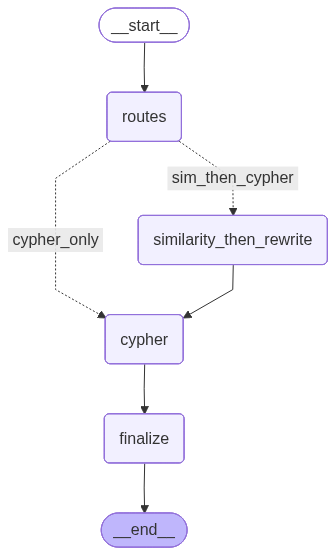

In [16]:
# Display a visual diagram of the application’s execution graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
# Example query
answer, path = ask("How many reference products are in the Chemical sector? List all of them.")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (rp:Reference_Product)-[:Has_Sector]->(s:Sector {name: 'Chemical'})
RETURN COUNT(rp) AS number_of_reference_products, COLLECT(rp.name) AS reference_product_names

Full Context:
[{'number_of_reference_products': 24, 'reference_product_names': ['p-Xylene', 'Sorbitol', 'Citric acid', 'FDCA', 'Levulinic acid', 'Furfural', 'Xylitol', 'Itaconic acid', '1,3-Butadiene', 'Butanol', 'Succinic acid', 'Acrylonitrile', 'Acrolein', 'Acrylic acid', 'Lactic acid', 'Propylene glycol', 'Propylene oxide', 'Propylene', 'Acetic acid', 'Ethylene glycol', 'Ethylene oxide', 'Ethylene', 'Formic acid', 'Methanol']}]

> Finished chain.
cypher_only
There are 24 reference products in the Chemical sector. They are p-Xylene, Sorbitol, Citric acid, FDCA, Levulinic acid, Furfural, Xylitol, Itaconic acid, 1,3-Butadiene, Butanol, Succinic acid, Acrylonitrile, Acrolein, Acrylic acid, Lactic acid, Propylene glycol, Propylene oxide, Propylene, Acet

In [18]:
answer, path = ask("Input and Output data of ethylene production from wood fermentation pathway")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'Ethylene production', technical_pathway: 'Wood Fermentation pathway'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[{'flow_name': 'Ethan', 'amount': 1.9, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Ethylene', 'amount': 5970.0, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Biogenic CO2', 'amount': 64400.0, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'CH4', 'amount': 245.6, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'CO', 'amount': 78.7, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'HC', 'amount': 0.1, 'unit': 'g', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'SO2', 'amount': 17.1, 'unit': 'g', 'flow_direction': 'Has_Outp

In [19]:
answer, path = ask("Input and Output data of ethylene production through technical_pathway Corn-grain-based pathway")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'Ethylene production', technical_pathway: 'Corn-grain-based pathway'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[{'flow_name': 'Cooling water', 'amount': 462.2, 'unit': 'GJ/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Makeup water', 'amount': 407.0, 'unit': 't/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Power', 'amount': 28.8, 'unit': 'MW', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Natural gas', 'amount': 693.6, 'unit': 'MMBTU/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'CO2 emissions', 'amount': 37.6, 'unit': 't/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Ethylene', 'amount': 125.0, 'unit': 'kt/h', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'NaOH', 'amount':

In [20]:
answer, path = ask("Give me some papers that uses cradle to gate as system boundary.")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Paper_Title)-[:Has_System_Boundary]->(s:System_Boundary {name: 'Cradle-to-gate'})
RETURN p.name AS paper_title

Full Context:
[{'paper_title': 'Life cycle assessment of fermentative production of lactic acid from bread waste based on process modelling using pinch technology'}, {'paper_title': 'Techno-economic and life cycle analysis of different types of hydrolysis process for the production of p-Xylene'}, {'paper_title': 'Life Cycle Assessment of Biobased p-Xylene Production'}, {'paper_title': 'Life-cycle sustainability of biomass-derived sorbitol: Proposing technological alternatives for improving the environmental profile of a bio-refinery platform molecule'}, {'paper_title': 'Towards improving the sustainability of bioplastics: Process modelling and life cycle assessment of two separation routes for 2,5-furandicarboxylic acid'}, {'paper_title': 'Environmental sustainability assessment of HMF and FDCA pro

In [21]:
answer, path = ask("All input and Output data of methanol production uses 'CO2' as  inputflow")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'Methanol production'})-[:Has_Input_Flow]->(f:Flow {name: 'CO2'})
RETURN f.name AS flow_name LIMIT 1
Full Context:
[{'flow_name': 'CO2'}]

> Finished chain.
sim_then_cypher
Yes, the Methanol production activity uses 'CO2' as an input flow.


In [22]:
answer, path = ask("List all flows associated with the activity methanol production in the pathway lignocellulosic biomass-based pathway (ADX LE).")
print(path)
print(answer)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Activity {name: 'Acetic acid production', technical_pathway: 'Lignocellulosic biomass-based pathway (ADX LE)'})
      -[o:Has_Output_Flow|Has_Input_Flow]->(f:Flow)
      -[:Has_Value]->(q:Amount)
      -[:Has_Unit]->(u:Unit)
RETURN f.name AS flow_name, q.value AS amount, u.name AS unit, type(o) AS flow_direction
Full Context:
[{'flow_name': 'CO2 (from natural gas)', 'amount': 1.4, 'unit': 't', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Lignin (bone dry)', 'amount': 440.0, 'unit': 'kg', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Acetic acid', 'amount': 1.0, 'unit': 't', 'flow_direction': 'Has_Output_Flow'}, {'flow_name': 'Electricity', 'amount': 300.0, 'unit': 'kWh', 'flow_direction': 'Has_Input_Flow'}, {'flow_name': 'Diisobutyl ketone (DIBK)', 'amount': 1.9, 'unit': 'kg', 'flow_direction': 'Has_Input_Flow'}, {'flow_name': 'Alamine', 'amount': 1.9, 'unit': 'kg', 'flow_direction': 'Has_Input_Flow'